In [78]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import HdpModel

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import itertools

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from ipywidgets import interact

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import enchant
pd.set_option('display.max_rows', 500)

In [79]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

manualtag=pd.read_csv(Path+'SamplesManualTagger.csv')


varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")


In [566]:
manualstopwords=['research','group','subject','process','development','analysis','model','different','new','process','study','change','system','approach', 'datum', 'high', 'structure', 'develop', 'allow']

In [567]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
newstopwords=varclusterall[(varclusterall.cluster_name=='General') | (varclusterall.cluster_name=='Text & Publish') ].Variable.tolist()+manualstopwords
#.sort_values(by='RS_Ratio')

In [568]:
df.PreProcessedDescription=[' '.join([words for words in abstract.split() if(not words in newstopwords)]) for abstract in df.PreProcessedDescription ]

In [569]:
# TF IDF Conversion

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
review_vectors = vectorizer.fit_transform(df["PreProcessedDescription"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
merged_data=pd.concat([df,features_df], axis=1,ignore_index=False)

#wordslist=merged_data.columns.tolist()[len(df.columns)+6:]

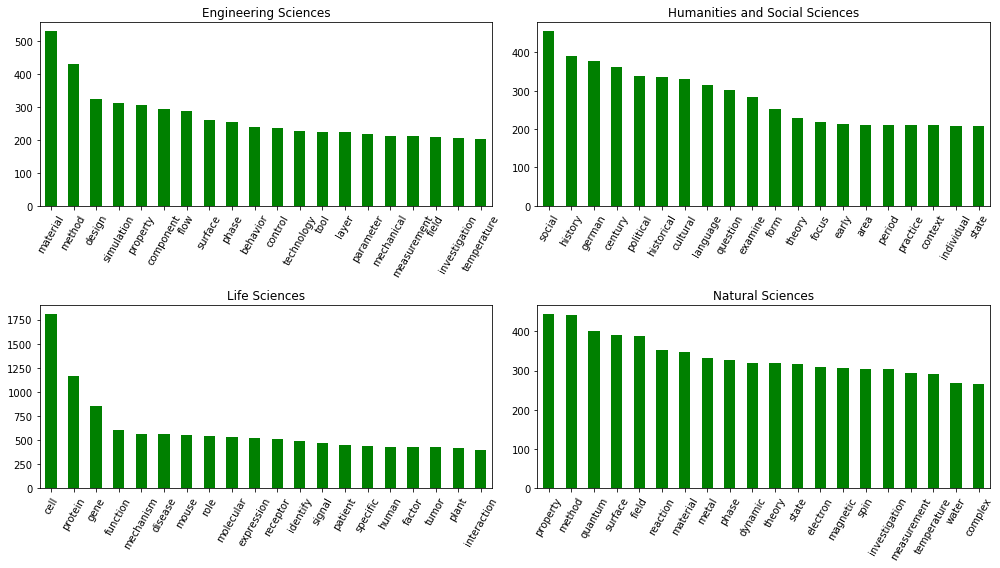

In [570]:
wordslist=merged_data.columns.tolist()[len(df.columns)+2:]

plt.subplots(figsize=(14,8)) 
i=1
categories=[]
category_words=[]

for cat,bucket in merged_data.groupby('Category'):
    
    plt.subplot(2,2,i)
    bucket[wordslist].sum().sort_values(ascending=False).head(20).plot(kind='bar',color='green')
    plt.title(cat)
    plt.xticks(rotation=60)
    i=i+1
    plt.tight_layout()
    categories.append(cat)
    category_words.append( ' '.join(bucket[wordslist].sum().sort_values(ascending=False).head(50).index.tolist()))

CategoryImpoWords=pd.DataFrame({'Category':categories,'Words':category_words})

In [571]:
## Repeated words in category

word=[]
for x in [cc.split() for cc in CategoryImpoWords.Words]:
    word.extend(x)
pd.Series(word).value_counts().sort_values(ascending=False).head(16)#.index.tolist()

order        3
important    3
area         3
molecular    2
field        2
control      2
problem      2
particle     2
analyze      2
condition    2
state        2
dynamic      2
method       2
knowledge    2
large        2
complex      2
dtype: int64

###### 1.1 Word Embedding

In [94]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=3, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list        
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [166]:
## creating a tagged document
#DescDict=make_bigram([[x for x in str(i).split()] for i in df.PreProcessedDescription])
DescDict=[[x for x in str(i).split()] for i in df.PreProcessedDescription]


#tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [587]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.Word2Vec(DescDict,size=50, min_count=1, alpha = 0.02, sg=0, seed=42, workers=4)

#### Hyper parameter ####
print(str(datetime.datetime.now()),'Completed')

2020-03-02 23:34:45.402760 Started
2020-03-02 23:35:39.180874 Completed


In [593]:
## Validating the model response for random words 

modelchecked=model
target_word='reaction'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=10), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'reaction' model: Word2Vec(vocab=139454, size=50, alpha=0.02) similar words:
    1. 0.77 'photochemical'
    2. 0.73 'hydrogenation'
    3. 0.72 'hydrodefluorination'
    4. 0.72 'catalyst'
    5. 0.72 'phosphaalkene'
    6. 0.72 'reactivity'
    7. 0.72 'catalysis'
    8. 0.71 'catalytic'
    9. 0.71 'radical'
    10. 0.71 'oxidation'


### LDA

In [543]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list

def buildLDA(processed_docs, ip_num_topics=4):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=10000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    
    return dictionary,bow_corpus,corpus_tfidf#, lda_model_tfidf

def LDAtopicSummary(model, displaysubplot=[2,2]):
    for idx, topic in model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords',"Text"]
    return(sent_topics_df)

def build_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()
    out_df=[]
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel.get_document_topics(corpus,minimum_probability=.2)):
        row = sorted(row_list, key=lambda x: x[1], reverse=True)
        inn_df=[]
        for num,prob in row:
            inn_df.append(num)
            inn_df.append(prob)
        out_df.append(np.array(inn_df))
            
    return out_df

In [99]:
docs=make_bigram(df["PreProcessedDescription"].map(preprocess))
print(str(len(docs))+' docs in input')

51033 docs in input


In [544]:
dictionary,bow_corpus,corpus_tfidf =buildLDA(docs)

In [551]:
#lda_model_tfidf = HdpModel(corpus_tfidf, id2word=dictionary,  random_state=42)
ip_num_topics=4
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, 
                                                 eta=[0.001]*len(dictionary.keys()), alpha =.001*ip_num_topics, random_state=42)

In [552]:
lda_model_tfidf.print_topics()

[(0,
  '0.004*"material" + 0.003*"property" + 0.002*"field" + 0.002*"surface" + 0.002*"state" + 0.002*"measurement" + 0.002*"phase" + 0.002*"control" + 0.002*"dynamic" + 0.002*"simulation"'),
 (1,
  '0.004*"specie" + 0.003*"protein" + 0.003*"plant" + 0.002*"soil" + 0.002*"evolution" + 0.002*"datum" + 0.002*"high resolution" + 0.002*"formation" + 0.002*"climate" + 0.002*"complex"'),
 (2,
  '0.002*"question" + 0.002*"datum" + 0.002*"focus" + 0.002*"form" + 0.002*"area" + 0.002*"history" + 0.002*"field" + 0.002*"individual" + 0.002*"examine" + 0.002*"knowledge"'),
 (3,
  '0.004*"protein" + 0.003*"disease" + 0.003*"mouse" + 0.003*"patient" + 0.003*"mechanism" + 0.003*"gene" + 0.002*"role" + 0.002*"expression" + 0.002*"response" + 0.002*"control"')]

In [218]:
#pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary=lda_model_tfidf.id2word)

In [616]:
def map_word_frequency(document):
    return Counter(itertools.chain(*document))
    
def get_sif_feature_vectors(sentence1, sentence2, word_emb_model=model):
    sentence1 = [token for token in sentence1.split() if token in word_emb_model.wv.vocab]
    sentence2 = [token for token in sentence2.split() if token in word_emb_model.wv.vocab]
    word_counts = map_word_frequency((sentence1 + sentence2))
    embedding_size = 50 # size of vectore in word embeddings
    a = 0.0001
    sentence_set=[]
    for sentence in [sentence1, sentence2]:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        for word in sentence:
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
        vs = np.divide(vs, sentence_length) # weighted average
        sentence_set.append(vs)
    return sentence_set

def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

def similarity_scores(sentence1, sentence2, n=10):
    sentence1=sentence1.replace(',','')
    sentence2=sentence2.replace(',','')
    features=get_sif_feature_vectors(sentence1, sentence2)
    return get_cosine_similarity(features[0][:n],features[1][:n])

In [617]:
topic_words=[]
for i in range(ip_num_topics):
    topic_words.append(", ".join([word for (word, value) in lda_model_tfidf.show_topic(i)]))

TopicDesc=pd.DataFrame({'TopicNo':range(ip_num_topics), 'topic_words':topic_words})

In [620]:
TopicDesc['Category_1']=''
TopicDesc['Category_2']=''

for i in range(ip_num_topics):
    topicWord=TopicDesc[TopicDesc.TopicNo==i].topic_words.values[0].replace(',','')
    max_1=0
    max_2=0
    scores=[]
    
    for j in CategoryImpoWords.Category.tolist():
        CatWords=CategoryImpoWords[CategoryImpoWords.Category==j].Words.values[0]
        score=similarity_scores(topicWord, CatWords,8)
        TopicDesc.loc[TopicDesc.TopicNo==i, j]=score
        scores.append(score)
    TopicDesc.loc[TopicDesc.TopicNo==i, 'Category_1']=CategoryImpoWords.Category.tolist()[pd.Series(scores).sort_values(ascending=False).head(1).index[0]]
    if(round(pd.Series(scores).sort_values(ascending=False).values[0]-pd.Series(scores).sort_values(ascending=False).values[1],2)<.12):
        TopicDesc.loc[TopicDesc.TopicNo==i, 'Category_2']=CategoryImpoWords.Category.tolist()[pd.Series(scores).sort_values(ascending=False).head(2).index[1]]
        
TopicDesc

,TopicNo,topic_words,Category_1,Category_2,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
0,0,"material, property, field, surface, state, mea...",Natural Sciences,Engineering Sciences,0.768690,0.216301,0.058896,0.845724
1,1,"specie, protein, plant, soil, evolution, datum...",Natural Sciences,,0.284586,0.035339,0.127191,0.706699
2,2,"question, datum, focus, form, area, history, f...",Humanities and Social Sciences,,0.662330,0.862564,-0.517557,-0.022909
3,3,"protein, disease, mouse, patient, mechanism, g...",Life Sciences,,-0.109917,-0.592622,0.917622,0.358778


In [604]:
TopicDesc.topic_words.tolist()

['material, property, field, surface, state, measurement, phase, control, dynamic, simulation',
 'specie, protein, plant, soil, evolution, datum, high resolution, formation, climate, complex',
 'question, datum, focus, form, area, history, field, individual, examine, knowledge',
 'protein, disease, mouse, patient, mechanism, gene, role, expression, response, control']

In [621]:
for c1 in CategoryImpoWords.Category:
    CategoryImpoWords[c1]=0
    for c2 in CategoryImpoWords.Category:
         CategoryImpoWords.loc[CategoryImpoWords.Category==c2,c1]=similarity_scores(CategoryImpoWords.loc[CategoryImpoWords.Category==c1, 'Words'].values[0],  CategoryImpoWords.loc[CategoryImpoWords.Category==c2, 'Words'].values[0]
                                                                                    ,7)
CategoryImpoWords

,Category,Words,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
0,Engineering Sciences,material method design simulation property com...,1.000000,0.712575,-0.194924,0.438650
1,Humanities and Social Sciences,social history german century political histor...,0.712575,1.000000,-0.670109,-0.103321
2,Life Sciences,cell protein gene function mechanism disease m...,-0.194924,-0.670109,1.000000,0.122429
3,Natural Sciences,property method quantum surface field reaction...,0.438650,-0.103321,0.122429,1.000000


In [622]:
CategoryImpoWords.Words.tolist()

['material method design simulation property component flow surface phase behavior control technology tool layer parameter mechanical measurement field investigation temperature influence production machine test particle order use problem stress increase algorithm numerical possible load alloy experimental condition optimization dynamic technique concept network sensor quality form large achieve area knowledge measure',
 'social history german century political historical cultural language question examine form theory focus early area period practice context individual state economic literature hand concept law policy knowledge european germany literary perspective central modern science basis religious society culture medium discourse analyze manuscript relationship important international national life collection public order',
 'cell protein gene function mechanism disease mouse role molecular expression receptor identify signal patient specific human factor tumor plant interaction 

In [624]:
size=len(df)

ls_expected_topic=[]
ls_expected_topic_cat=[]
ls_newwords=[]
ls_sim_score=[]

with tqdm(total=size) as bar:
    for i in range(size):
        result=lda_model_tfidf.get_document_topics(corpus_tfidf[i],per_word_topics=True)
        cids=[c_id  for (c_id,c_topic) in  result[1] if(c_topic)]

        expected_topic=result[0][0][0]
        expected_topic_cat= TopicDesc.loc[TopicDesc.TopicNo==expected_topic,'Category_1'].values[0]
        newwords=' '.join([dictionary[i] for i in cids])
        Catwords=CategoryImpoWords.loc[CategoryImpoWords.Category==df.loc[i,"Category"],'Words'].tolist()[0]   
        #if((len(Catwords)==0) or (len(newwords)==0)):
            #print(i,df.loc[i,"Category"],expected_topic,expected_topic_cat,':',newwords,'--',topicwords,sim_score)
        #    print(i,newwords,result)
        if(len(newwords)==0):
            sim_score=0
        else:
            sim_score=similarity_scores(newwords,Catwords,10)

        ls_expected_topic.append(expected_topic)
        ls_expected_topic_cat.append(expected_topic_cat)
        ls_newwords.append(newwords)
        ls_sim_score.append(sim_score)
        bar.update(1)
    
SimilarityPoints=pd.DataFrame({'Topic':ls_expected_topic, 'Top_Category':ls_expected_topic_cat,'Desc_words':ls_newwords, 'Similarity':ls_sim_score  })

100%|██████████| 51033/51033 [03:33<00:00, 238.88it/s]


In [625]:
merged_df1=pd.concat([df,SimilarityPoints],ignore_index=True, axis=1)
merged_df1.columns=df.columns.tolist()+SimilarityPoints.columns.tolist()

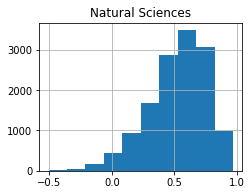

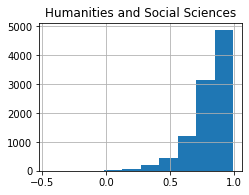

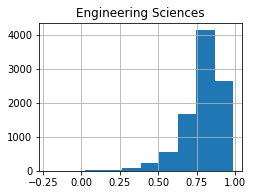

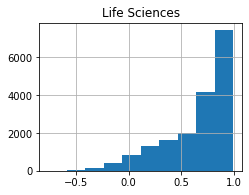

In [626]:
i=1
for cc in merged_df1.Category.unique():
    plt.figure(figsize=(8, 6))
    plt.subplot(2,2,i)
    merged_df1[(merged_df1['Category']==cc)]['Similarity'].hist()
    plt.title(cc)
    i=i+1

In [627]:
merged_df1[(merged_df1['Similarity']<.5)].Category.value_counts()

Natural Sciences                  5583
Life Sciences                     4699
Humanities and Social Sciences     533
Engineering Sciences               313
Name: Category, dtype: int64

In [637]:
merged_df1[(merged_df1['Similarity']>.5) & (merged_df1['Category']=='Life Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,File_Categories,Category,Topic,Top_Category,Desc_words,Similarity
19,GRK 268:&nbsp; Dynamics and Evolution of Cellu...,/gepris/projekt/271461,1997,2006,Fundamental Biological and Medical Research,Humboldt-Universität zu Berlin,The aim of the research training group is to e...,The aim of the research training group is to e...,GRK 268:&nbsp; Dynamics and Evolution of Cellu...,training elucidate dynamic property macromolec...,Fundamental Biological and Medical Research,Life Sciences,0,Natural Sciences,training analyse field theory mathematical the...,0.506225
21,GRK 276:&nbsp; Signal Recognition and Transduc...,/gepris/projekt/271543,1996,2005,Fundamental Biological and Medical Research,Freie Universität Berlin,The research training group 'Signal Recognitio...,The research training group 'Signal Recognitio...,GRK 276:&nbsp; Signal Recognition and Transduc...,training signal recognition transduction inter...,Fundamental Biological and Medical Research,Life Sciences,3,Life Sciences,training essential approach field special emph...,0.560795
25,GRK 288:&nbsp; Structures and Mediators of the...,/gepris/projekt/271645,1997,2005,Fundamental Biological and Medical Research,Universität zu Lübeck,It is the aim of the research training group t...,It is the aim of the research training group t...,GRK 288:&nbsp; Structures and Mediators of the...,training encourage bond cooperation molecular ...,Fundamental Biological and Medical Research,Life Sciences,2,Humanities and Social Sciences,natural science training major experimental st...,0.543859
30,GRK 320:&nbsp; Pathological Processes of the N...,/gepris/projekt/271797,1997,2006,Medicine,Heinrich-Heine-Universität Düsseldorf,The aim of the research training group is an i...,The aim of the research training group is an i...,GRK 320:&nbsp; Pathological Processes of the N...,training interdisciplinary pathological pathop...,Medicine,Life Sciences,2,Humanities and Social Sciences,training relate generation level nervous inves...,0.698575
33,GRK 336:&nbsp; Molecular Endocrinology - Molec...,/gepris/projekt/271937,1997,2006,Fundamental Biological and Medical Research,Universität Hamburg,The Kolleg brings together 12 groups actively ...,The Kolleg brings together 12 groups actively ...,GRK 336:&nbsp; Molecular Endocrinology - Molec...,kolleg bring actively molecular level aspect o...,Fundamental Biological and Medical Research,Life Sciences,2,Humanities and Social Sciences,special training aspect level field molecular ...,0.830444
39,GRK 377:&nbsp; Cellular Regulation and Growth,/gepris/projekt/272107,1998,2006,Fundamental Biological and Medical Research,Universität des Saarlandes,Regulation of cellular processes and in partic...,Regulation of cellular processes and in partic...,GRK 377:&nbsp; Cellular Regulation and Growth,regulation cellular particular control cell di...,Fundamental Biological and Medical Research,Life Sciences,3,Life Sciences,natural science control single student factor ...,0.879119
53,GRK 455:&nbsp; Molecular Veterinary Medicine,/gepris/projekt/272499,1998,2007,"Agriculture, Forestry and Veterinary Medicine",Justus-Liebig-Universität Gießen,Molecular cell structures determine complex di...,Molecular cell structures determine complex di...,GRK 455:&nbsp; Molecular Veterinary Medicine,molecular cell complex disease successful vete...,"Agriculture, Forestry and Veterinary Medicine",Life Sciences,2,Humanities and Social Sciences,training complex student importance interactio...,0.806051
66,GRK 534:&nbsp; Biological Basis of Vascular Me...,/gepris/projekt/272805,1999,2008,Medicine,Justus-Liebig-Universität Gießen,The aim of this research training group is to ...,The aim of this research training group is to ...,GRK 534:&nbsp; Biological Basis of Vascular Me...,training graduate indepth knowledge basic aspe...,Medicine,Life Sciences,3,Life Sciences,orient question 

In [638]:
merged_df1[(merged_df1['Similarity']>.5) & (merged_df1['Category']=='Life Sciences')].head(10).PreProcessedDescription.tolist()

['training elucidate dynamic property macromolecule cellular tight interaction theory understand amazing experimental complex biological particular cell structural molecular biology mathematical mandatory successful physical mathematical method modern biology hamper hand limited training biologist mathematic physics hand limited biological knowledge physicist mathematician chemist proram overcome problem concerted supervision phd student interdisciplinary lecture course seminar field experimental phd student analyse theoretical level field theory able mathematical theoretical concept strong relevance biological main dynamic cellular reaction transport macromolecular dynamic function genome sequence genetic network',
 'training signal recognition transduction interdisciplinary collaboration clinical basic science field molecular medicine modern training course continually adapt specific demand intersect field training basic clinician join mechanism cellular signal recognition transducti

In [634]:
topic_df=pd.DataFrame(build_topics_sentences(lda_model_tfidf,corpus_tfidf))

In [635]:
merged_topic_df=topic_df.merge(TopicDesc,how='left', left_on=0, right_on='TopicNo')[[0, 1, 2, 3, 'topic_words','Category_1','Category_2']]
merged_topic_df=merged_topic_df.merge(TopicDesc,how='left', left_on=2, right_on='TopicNo')[[0, 1, 2, 3, 'topic_words_x','Category_1_x','Category_2_x','topic_words_y','Category_1_y','Category_2_y']]
merged_topic_df.columns=['Topic_1', 'Perc_cont_1', 'Topic_2', 'Perc_cont_2', 'important_topic_words_1','Category_1_1','Category_1_2', 'important_topic_words_2','Category_2_1','Category_2_2']
merged_topic_df=merged_topic_df.reset_index()[merged_topic_df.columns]

merged_df=pd.concat([df,merged_topic_df],ignore_index=True, axis=1)
merged_df.columns=df.columns.tolist()+merged_topic_df.columns.tolist()

In [636]:
for (t1,c11,c12),w in merged_df.groupby(['Topic_1','Category_1_1','Category_1_2']):
    print(t1,c11,c12)
    print(w.Category.value_counts())

0.0 Natural Sciences Engineering Sciences
Natural Sciences                  9908
Engineering Sciences              8085
Life Sciences                     1438
Humanities and Social Sciences     285
Name: Category, dtype: int64
1.0 Natural Sciences 
Natural Sciences                  2466
Life Sciences                     2348
Engineering Sciences                84
Humanities and Social Sciences      38
Name: Category, dtype: int64
2.0 Humanities and Social Sciences 
Humanities and Social Sciences    9338
Life Sciences                     1240
Engineering Sciences              1100
Natural Sciences                  1055
Name: Category, dtype: int64
3.0 Life Sciences 
Life Sciences                     12923
Humanities and Social Sciences      323
Natural Sciences                    295
Engineering Sciences                107
Name: Category, dtype: int64


In [329]:
merged_df[['SubjectArea', 'File_Categories','Category', 'Topic_1',
       'Perc_cont_1', 'Topic_2', 'Perc_cont_2','Category_1_1','Category_1_2','Category_2_1','Category_2_2']].head()

,SubjectArea,File_Categories,Category,Topic_1,Perc_cont_1,Topic_2,Perc_cont_2,Category_1_1,Category_1_2,Category_2_1,Category_2_2
0,Mathematics,Mathematics,Natural Sciences,1.0,0.972391,NaN,NaN,Humanities and Social Sciences,Engineering Sciences,NaN,NaN
1,Social Sciences,Social Sciences,Humanities and Social Sciences,1.0,0.979490,NaN,NaN,Humanities and Social Sciences,Engineering Sciences,NaN,NaN
2,Production Technology,Production Technology,Engineering Sciences,3.0,0.978472,NaN,NaN,Engineering Sciences,Natural Sciences,NaN,NaN
3,Condensed Matter Physics,Condensed Matter Physics,Natural Sciences,3.0,0.980316,NaN,NaN,Engineering Sciences,Natural Sciences,NaN,NaN
4,Construction Engineering and Architecture,Construction Engineering and Architecture,Engineering Sciences,3.0,0.979965,NaN,NaN,Engineering Sciences,Natural Sciences,NaN,NaN
